<a href="https://colab.research.google.com/github/AldiZulfikar/devops_dtl/blob/master/Model/DTL_Skripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jcopdl
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gdown https://drive.google.com/uc?id=1ZmBOBhZV0Nc5OigGfkcH5Az6tQrymdBV

Downloading...
From: https://drive.google.com/uc?id=1ZmBOBhZV0Nc5OigGfkcH5Az6tQrymdBV
To: /content/Dataset.zip
100% 6.63M/6.63M [00:00<00:00, 269MB/s]


In [3]:
!unzip /content/Dataset.zip

Archive:  /content/Dataset.zip
replace Dataset/log4j-1.1/buggy/SysoutConfigurator.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset/log4j-1.1/buggy/SysoutConfigurator.png  
replace Dataset/log4j-1.1/buggy/JMSAppender.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset/log4j-1.1/buggy/JMSAppender.png  
replace Dataset/log4j-1.1/buggy/SocketAppender.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset/log4j-1.1/buggy/SocketAppender.png  
replace Dataset/log4j-1.1/buggy/Priority.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset/log4j-1.1/buggy/Priority.png  
replace Dataset/log4j-1.1/buggy/SocketNode.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset/log4j-1.1/buggy/SocketNode.png  
replace Dataset/log4j-1.1/buggy/RollingFileAppender.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset/log4j-1.1/buggy/RollingFileAppender.png  
replace Dataset/log4j-1.1/buggy/PropertyGetter.png? [y]es, [n]o, [A]ll, [N]on

In [4]:
!ls /content/Dataset

ant-1.6-preprop  log4j-1.0  log4j-1.1  poi-3.0-preprop


# Eksplore data

In [5]:
import os 
for dirpath, dirnames, filenames in os.walk("/content/Dataset/ant-1.6-preprop/"):
  print(f"Ada {len(dirnames)} direktori dan {len(filenames)} gambar di dalam {dirpath}")

Ada 2 direktori dan 0 gambar di dalam /content/Dataset/ant-1.6-preprop/
Ada 0 direktori dan 91 gambar di dalam /content/Dataset/ant-1.6-preprop/buggy
Ada 0 direktori dan 258 gambar di dalam /content/Dataset/ant-1.6-preprop/clean


In [6]:
for dirpath, dirnames, filenames in os.walk("/content/Dataset/log4j-1.1/"):
  print(f"Ada {len(dirnames)} direktori dan {len(filenames)} gambar di dalam {dirpath}")

Ada 2 direktori dan 0 gambar di dalam /content/Dataset/log4j-1.1/
Ada 0 direktori dan 37 gambar di dalam /content/Dataset/log4j-1.1/buggy
Ada 0 direktori dan 65 gambar di dalam /content/Dataset/log4j-1.1/clean


In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Ukuran gambar:{img.shape}")
  return img


Ukuran gambar:(128, 118, 3)


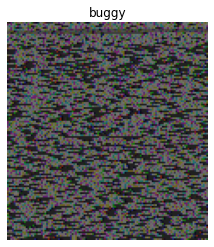

In [8]:
img = view_random_image("/content/Dataset/ant-1.6-preprop/", "buggy")

# Dataset & Data Loader

In [9]:
import numpy as np
import os
from PIL import Image, ImageOps
import numbers
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.callback import Callback, set_config
from tqdm.auto import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
batch_size = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = datasets.ImageFolder("/content/Dataset/ant-1.6-preprop/", transform = train_transform)
trainloader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers=4)

test_set = datasets.ImageFolder("/content/Dataset/log4j-1.1/", transform = test_transform)
testloader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
label_data = train_set.classes
label_data

['buggy', 'clean']

# Arsitektur & Config

In [12]:
from torchvision.models import resnet50, ResNet50_Weights
from torch import nn, optim

In [13]:
class ModelResNet(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.freeze()
        self.model.fc = nn.Sequential(
            nn.Linear(2048, 2),
            nn.LogSoftmax(1)
        )
        
    def forward(self, x):
        return self.model(x)
    
    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False
            
    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [14]:
config = set_config({
    "output_size": len(label_data),
    "batch_size": batch_size,
    "crop_size": crop_size
})

# Phase 1 : Adaptation (Ir standard + patience kecil)

In [15]:
model = ModelResNet(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [16]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.5459 | Test_cost  = 0.6742 | Train_score = 0.7364 | Test_score = 0.6373 |


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.4696 | Test_cost  = 0.6683 | Train_score = 0.7393 | Test_score = 0.6471 |


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.4375 | Test_cost  = 0.6739 | Train_score = 0.7851 | Test_score = 0.7157 |


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.4269 | Test_cost  = 0.7510 | Train_score = 0.8052 | Test_score = 0.6569 |
==> EarlyStop patience =  1 | Best test_score: 0.7157


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.4082 | Test_cost  = 0.8806 | Train_score = 0.8166 | Test_score = 0.6471 |
==> EarlyStop patience =  2 | Best test_score: 0.7157
==> Execute Early Stopping at epoch: 5 | Best test_score: 0.7157
==> Best model is saved at model


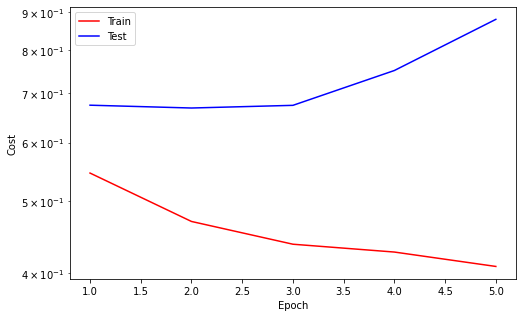

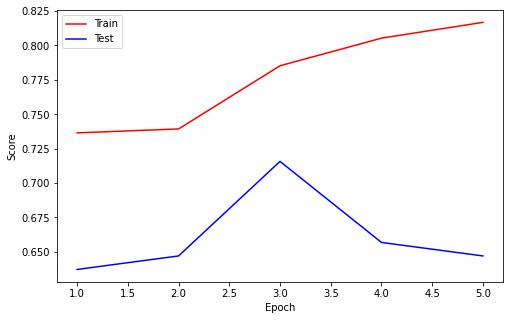

In [17]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

# Phase 2 : Adaptation (Ir kecil + patience besar)

In [18]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4151 | Test_cost  = 0.7680 | Train_score = 0.8080 | Test_score = 0.6961 |
==> EarlyStop patience =  1 | Best test_score: 0.7157


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4078 | Test_cost  = 0.8570 | Train_score = 0.8109 | Test_score = 0.6471 |
==> EarlyStop patience =  2 | Best test_score: 0.7157


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4039 | Test_cost  = 0.9012 | Train_score = 0.8023 | Test_score = 0.6373 |
==> EarlyStop patience =  3 | Best test_score: 0.7157


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3930 | Test_cost  = 0.9440 | Train_score = 0.8166 | Test_score = 0.6275 |
==> EarlyStop patience =  4 | Best test_score: 0.7157


Train:   0%|          | 0/6 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3769 | Test_cost  = 0.9633 | Train_score = 0.8195 | Test_score = 0.6275 |
==> EarlyStop patience =  5 | Best test_score: 0.7157
==> Execute Early Stopping at epoch: 10 | Best test_score: 0.7157
==> Best model is saved at model


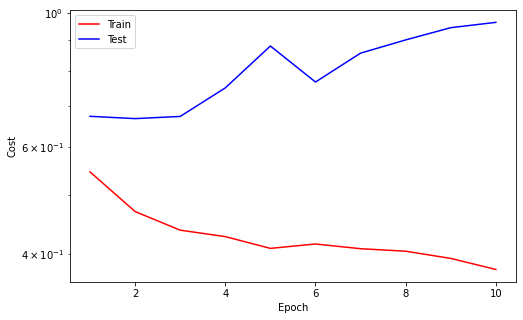

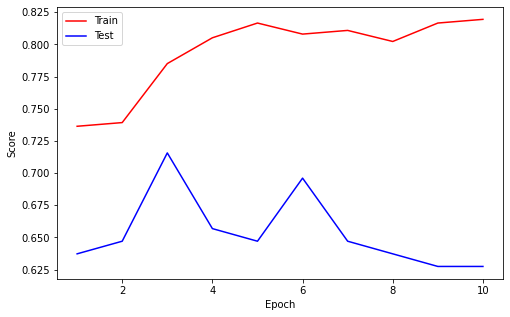

In [19]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

In [20]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [21]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')

# Sanity Check

In [22]:
def inverse_norm(img):
  img[0, :, :] = img[0, :, :] * 0.229 + 0.485
  img[1, :, :] = img[1, :, :] * 0.224 + 0.456
  img[2, :, :] = img[2, :, :] * 0.225 + 0.406
  return img

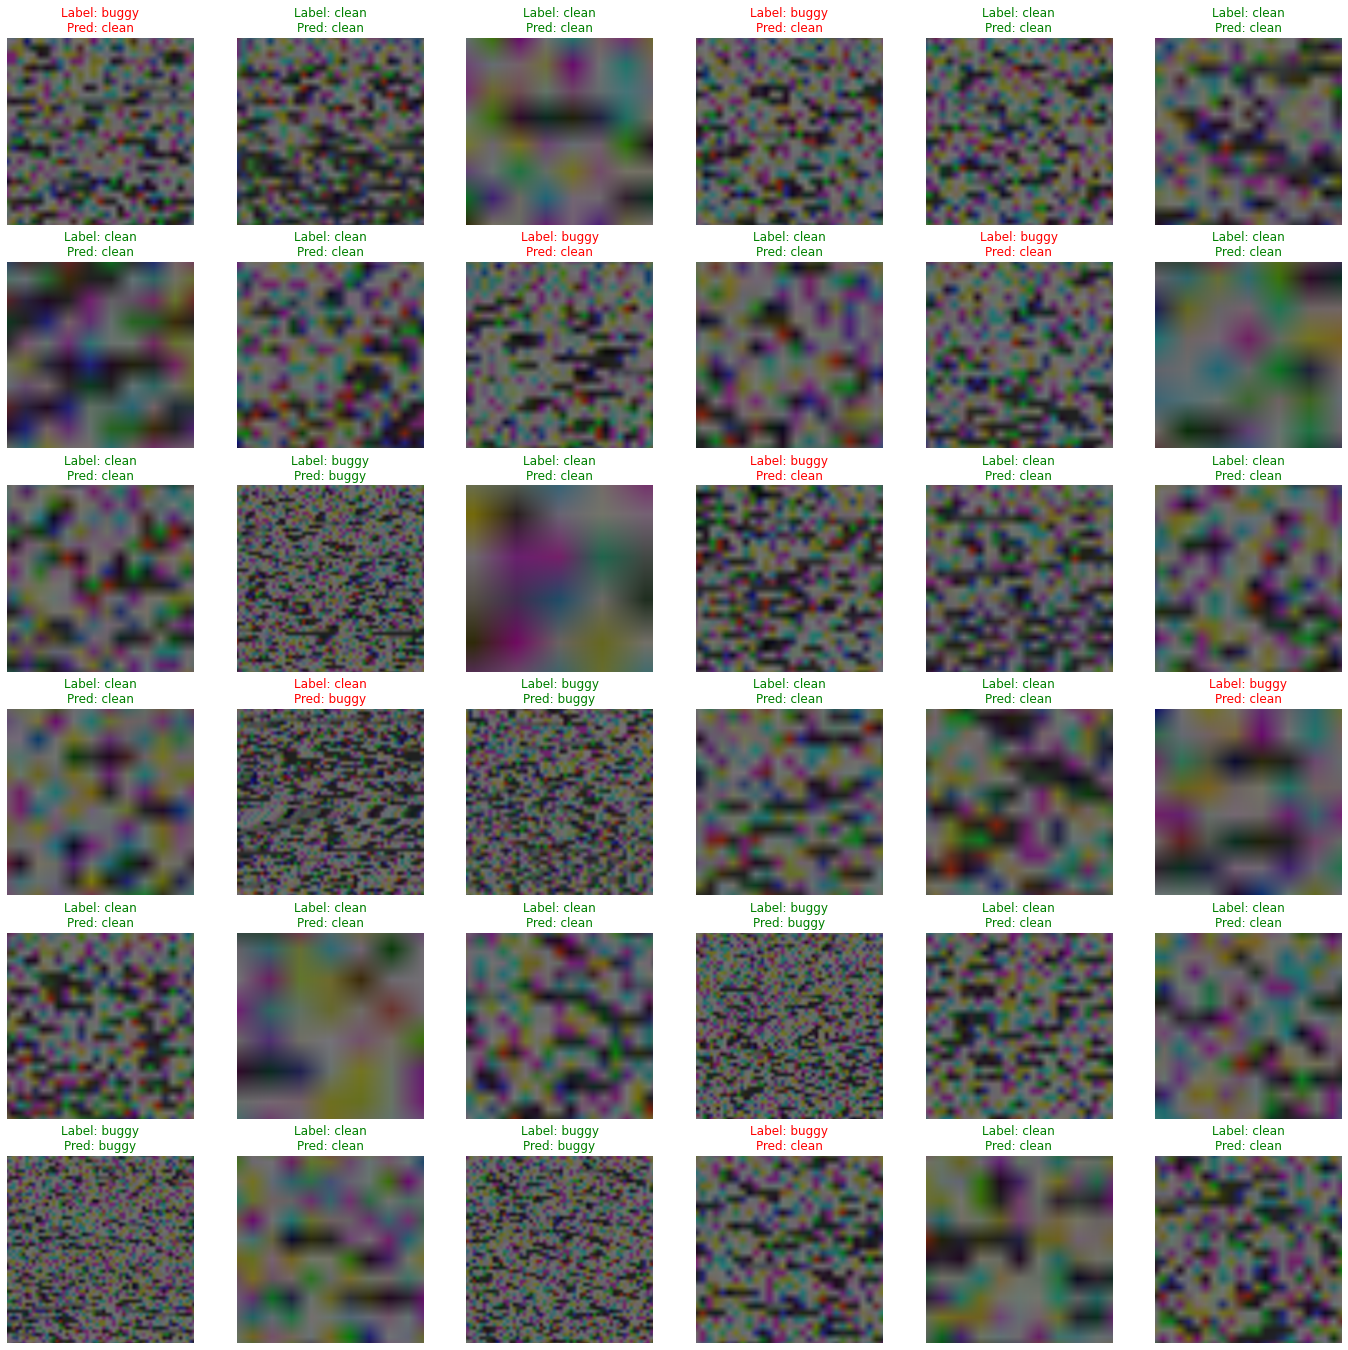

In [23]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(inverse_norm(img).permute(1,2,0).cpu())
  font = {"color":'r'} if label != pred else {"color": 'g'}
  label, pred = label_data[label.item()], label_data[pred.item()]
  ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
  ax.axis("off");

In [24]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/logs.pth (deflated 48%)
  adding: content/model/weights_best.pth (deflated 7%)
  adding: content/model/configs.pth (deflated 51%)


In [25]:
weights = torch.load("/content/model/weights_best.pth", map_location='cpu')

In [26]:
model.load_state_dict(weights)
model = model.to(device)

In [27]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  pred = output.argmax(1)
  acc = (target == pred).to(torch.float32).mean()
acc

tensor(0.7344, device='cuda:0')